In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU is ready to be used: {gpus[0].name}")
else:
    print("GPU is NOT available.")


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))


In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Available devices:")
print(device_lib.list_local_devices())

In [ ]:
import tensorflow as tf
print(tf.__version__)


In [26]:
# Import necessary libraries
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from scipy.sparse import lil_matrix, csr_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, KFold

# For inline plots
%matplotlib inline

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /home/camelot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/camelot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/camelot/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [27]:
# Load text file
filename = "text8.txt"  # Replace with your file path
with open(filename, "r", encoding="utf-8") as f:
    text = f.read()

# Clean text
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r'[^\x00-\x7F]+', ' ', txt)  # Remove non-ASCII characters
    txt = re.sub(r'\d+', '', txt)            # Remove digits
    txt = re.sub(r'[^\w\s]', '', txt)        # Remove punctuation
    return txt

text = clean_text(text)
print(f"Text after cleaning (sample): {text[:200]}")


Text after cleaning (sample):  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term 


In [28]:
# Tokenize text
tokens = word_tokenize(text)

# Remove stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))
tokens = [t for t in tokens if t not in stop_words and t.strip() != ""]
print(f"Number of tokens after cleaning and stopword removal: {len(tokens)}")


Number of tokens after cleaning and stopword removal: 10888361


In [29]:
# Count word frequencies
freq = Counter(tokens)
most_common = freq.most_common()

# Limit vocabulary size
vocab_size = 5000
vocab_list = [w for w, _ in most_common[:vocab_size]]
vocab = {word: idx for idx, word in enumerate(vocab_list)}

# Filter tokens based on vocabulary
filtered_tokens = [t for t in tokens if t in vocab_list]

# Train-test split
train_tokens, val_tokens = train_test_split(filtered_tokens, test_size=0.2, random_state=42)


In [30]:
# Filter training tokens based on vocabulary
filtered_train_tokens = [t for t in train_tokens if t in vocab_list]

# Rebuild the word index for the top 5,000 vocabulary
word_index = {word: idx for idx, word in enumerate(vocab_list)}

# Initialize sparse co-occurrence matrix
window_size = 2
co_matrix_sparse = lil_matrix((len(vocab_list), len(vocab_list)), dtype=int)

# Build co-occurrence matrix
for i, word in enumerate(filtered_train_tokens):
    for j in range(max(0, i - window_size), min(len(filtered_train_tokens), i + window_size + 1)):
        if i != j:
            co_matrix_sparse[word_index[word], word_index[filtered_train_tokens[j]]] += 1

# Convert to CSR format
co_matrix_sparse = csr_matrix(co_matrix_sparse)


In [31]:
# Normalize and reduce dimensions
normalized_matrix = normalize(co_matrix_sparse, norm='l2', axis=1)
svd = TruncatedSVD(n_components=10, random_state=42)
reduced_matrix = svd.fit_transform(normalized_matrix)


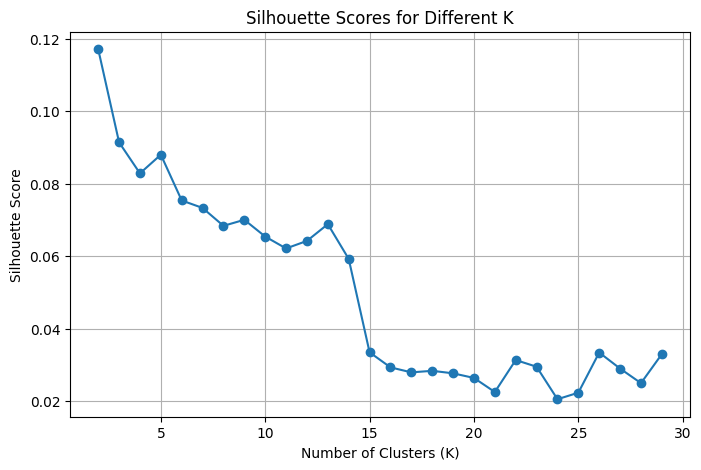

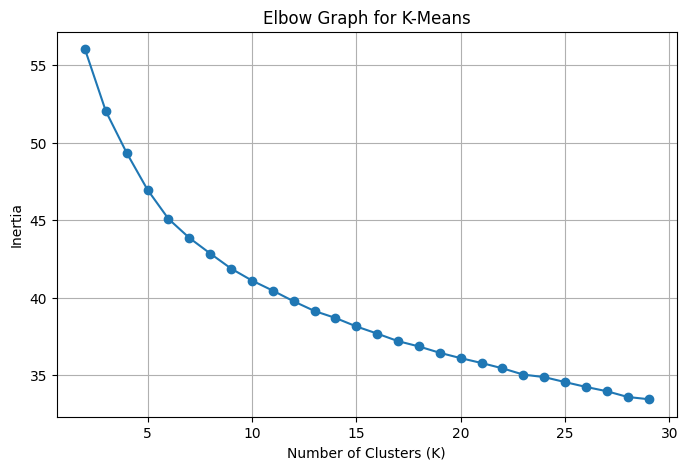

In [32]:
# Silhouette scores
k_values = range(2, 30)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reduced_matrix)
    labels = kmeans.labels_
    score = silhouette_score(reduced_matrix, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

# Elbow method (Inertia)
inertia_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reduced_matrix)
    inertia_scores.append(kmeans.inertia_)

# Plot inertia scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_scores, marker='o')
plt.title("Elbow Graph for K-Means")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid()
plt.show()


K=2, Avg Silhouette Score: 0.2117
K=3, Avg Silhouette Score: 0.1655
K=4, Avg Silhouette Score: 0.1373
K=5, Avg Silhouette Score: 0.1299
K=6, Avg Silhouette Score: 0.0971
K=7, Avg Silhouette Score: 0.0721
K=8, Avg Silhouette Score: 0.0738
K=9, Avg Silhouette Score: 0.0719
K=10, Avg Silhouette Score: 0.0545
K=11, Avg Silhouette Score: 0.0617
K=12, Avg Silhouette Score: 0.0400
K=13, Avg Silhouette Score: 0.0401
K=14, Avg Silhouette Score: 0.0315
K=15, Avg Silhouette Score: 0.0120
K=16, Avg Silhouette Score: 0.0182
K=17, Avg Silhouette Score: 0.0151
K=18, Avg Silhouette Score: 0.0066
K=19, Avg Silhouette Score: 0.0172
K=20, Avg Silhouette Score: 0.0031


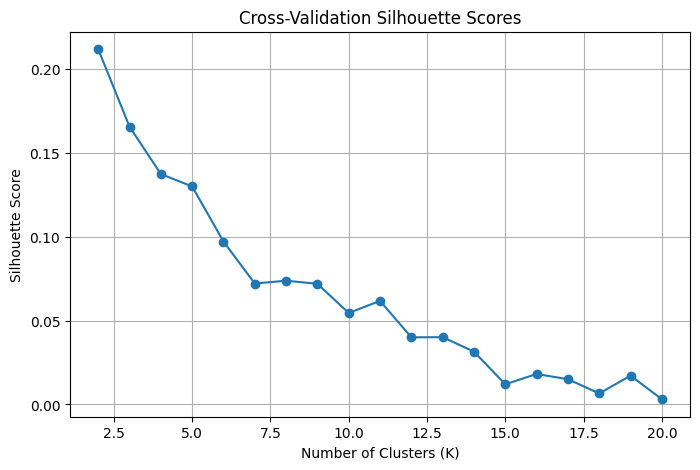

In [33]:
from sklearn.model_selection import KFold

def silhouette_scores_cv(X, max_k=10, n_folds=5):
    k_values = range(2, max_k + 1)
    avg_scores = []

    for k in k_values:
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        fold_scores = []

        for train_idx, test_idx in kf.split(X):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X[train_idx])
            labels = kmeans.predict(X[test_idx])
            score = silhouette_score(X[test_idx], labels, metric="cosine")
            fold_scores.append(score)

        avg_scores.append(np.mean(fold_scores))
        print(f"K={k}, Avg Silhouette Score: {np.mean(fold_scores):.4f}")

    return avg_scores

# Calculate and plot cross-validation silhouette scores
cv_scores = silhouette_scores_cv(reduced_matrix, max_k=20)
plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), cv_scores, marker='o')
plt.title("Cross-Validation Silhouette Scores")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()


In [34]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
from scipy.sparse import dok_matrix

# Normalize the co-occurrence matrix (if not already normalized)
co_matrix_normalized = normalize(co_matrix_sparse, norm='l2', axis=1)

# Number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define range of k values
k_values = range(2, 31)

# Store results for each k
inertia_results = []
ch_score_results = []
db_score_results = []

# Perform cross-validation for each k
for k in tqdm(k_values, desc="Cross-validation for optimal k"):
    fold_inertias = []
    fold_ch_scores = []
    fold_db_scores = []

    for train_index, test_index in kf.split(co_matrix_normalized):
        # Split the data into training and testing sets
        train_data = co_matrix_normalized[train_index]
        test_data = co_matrix_normalized[test_index]

        # Train KMeans on the training data
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit_predict(train_data)

        # Predict clusters for the testing data
        test_clusters = kmeans.predict(test_data)
        test_centers = kmeans.cluster_centers_

        # Calculate inertia for testing data
        test_inertia = 0
        for i in range(k):
            mask = test_clusters == i
            if np.any(mask):
                cluster_points = test_data[mask]
                center = dok_matrix(test_centers[i].reshape(1, -1))
                squared_norm = cluster_points.multiply(cluster_points).sum(axis=1)
                center_norm = center.multiply(center).sum()
                cross_term = 2 * cluster_points.dot(center.T)
                cluster_inertia = squared_norm + center_norm - cross_term
                test_inertia += cluster_inertia.sum()
        fold_inertias.append(test_inertia)

        # Calculate CH and DB scores
        if len(set(test_clusters)) > 1:  # Ensure at least 2 clusters are present
            ch_score = calinski_harabasz_score(test_data.toarray(), test_clusters)
            db_score = davies_bouldin_score(test_data.toarray(), test_clusters)

            fold_ch_scores.append(ch_score)
            fold_db_scores.append(db_score)

    # Store average scores
    avg_inertia = np.mean(fold_inertias)
    avg_ch = np.mean(fold_ch_scores) if fold_ch_scores else 0
    avg_db = np.mean(fold_db_scores) if fold_db_scores else 0

    inertia_results.append(avg_inertia)
    ch_score_results.append(avg_ch)
    db_score_results.append(avg_db)

# Print results
print("Cross-Validation Results:")
print(f"Inertia Results: {inertia_results}")
print(f"Calinski-Harabasz Scores: {ch_score_results}")
print(f"Davies-Bouldin Scores: {db_score_results}")


Cross-validation for optimal k: 100%|██████████| 29/29 [06:16<00:00, 12.97s/it]

Cross-Validation Results:
Inertia Results: [np.float64(64.61046175072195), np.float64(64.31782949019471), np.float64(64.31849950669913), np.float64(63.52694961682762), np.float64(62.92074538506919), np.float64(62.91825714465752), np.float64(62.68145717645662), np.float64(62.40805979286533), np.float64(62.40973995149748), np.float64(62.306059766049486), np.float64(62.15368084733982), np.float64(62.152826283085815), np.float64(62.15434527836281), np.float64(62.151366046605816), np.float64(61.9631608679418), np.float64(61.96241152894113), np.float64(61.89093901376266), np.float64(61.82892791230265), np.float64(61.82863560963053), np.float64(62.01363623382788), np.float64(62.01541771016817), np.float64(61.98421200617948), np.float64(61.983554501847834), np.float64(61.980039390867034), np.float64(61.98581584164661), np.float64(61.98670901863541), np.float64(61.987930483691414), np.float64(61.98757402190658), np.float64(61.95283134313879)]
Calinski-Harabasz Scores: [np.float64(26.85571451688

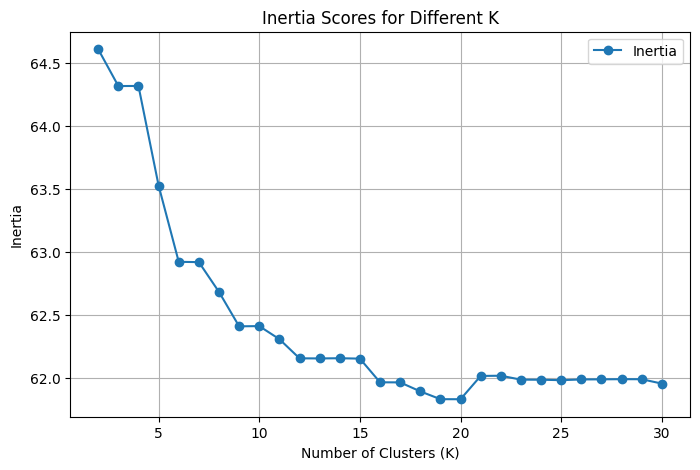

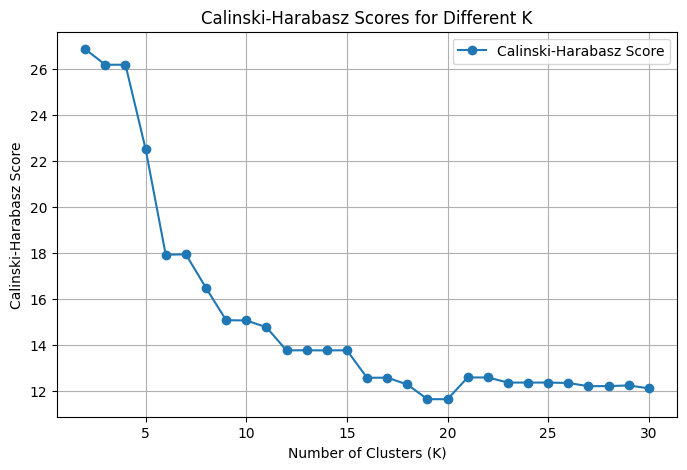

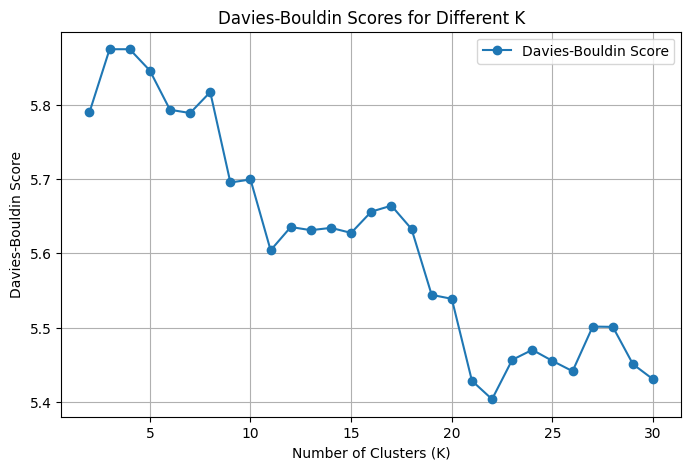

In [35]:
# Plot inertia scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_results, marker='o', label='Inertia')
plt.title("Inertia Scores for Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid()
plt.legend()
plt.show()

# Plot Calinski-Harabasz scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, ch_score_results, marker='o', label='Calinski-Harabasz Score')
plt.title("Calinski-Harabasz Scores for Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Calinski-Harabasz Score")
plt.grid()
plt.legend()
plt.show()

# Plot Davies-Bouldin scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_score_results, marker='o', label='Davies-Bouldin Score')
plt.title("Davies-Bouldin Scores for Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Davies-Bouldin Score")
plt.grid()
plt.legend()
plt.show()

Calculating Silhouette Scores:   3%|▎         | 1/29 [00:00<00:10,  2.74it/s]

K=2, Silhouette Score=0.1171


Calculating Silhouette Scores:   7%|▋         | 2/29 [00:00<00:12,  2.10it/s]

K=3, Silhouette Score=0.0914


Calculating Silhouette Scores:  10%|█         | 3/29 [00:01<00:13,  1.92it/s]

K=4, Silhouette Score=0.0829


Calculating Silhouette Scores:  14%|█▍        | 4/29 [00:02<00:13,  1.79it/s]

K=5, Silhouette Score=0.0880


Calculating Silhouette Scores:  17%|█▋        | 5/29 [00:02<00:14,  1.71it/s]

K=6, Silhouette Score=0.0754


Calculating Silhouette Scores:  21%|██        | 6/29 [00:03<00:15,  1.53it/s]

K=7, Silhouette Score=0.0733


Calculating Silhouette Scores:  24%|██▍       | 7/29 [00:04<00:14,  1.50it/s]

K=8, Silhouette Score=0.0684


Calculating Silhouette Scores:  28%|██▊       | 8/29 [00:04<00:14,  1.49it/s]

K=9, Silhouette Score=0.0701


Calculating Silhouette Scores:  31%|███       | 9/29 [00:05<00:14,  1.39it/s]

K=10, Silhouette Score=0.0654


Calculating Silhouette Scores:  34%|███▍      | 10/29 [00:06<00:14,  1.31it/s]

K=11, Silhouette Score=0.0622


Calculating Silhouette Scores:  38%|███▊      | 11/29 [00:07<00:13,  1.31it/s]

K=12, Silhouette Score=0.0642


Calculating Silhouette Scores:  41%|████▏     | 12/29 [00:08<00:13,  1.31it/s]

K=13, Silhouette Score=0.0689


Calculating Silhouette Scores:  45%|████▍     | 13/29 [00:08<00:12,  1.27it/s]

K=14, Silhouette Score=0.0593


Calculating Silhouette Scores:  48%|████▊     | 14/29 [00:09<00:12,  1.22it/s]

K=15, Silhouette Score=0.0335


Calculating Silhouette Scores:  52%|█████▏    | 15/29 [00:10<00:11,  1.23it/s]

K=16, Silhouette Score=0.0293


Calculating Silhouette Scores:  55%|█████▌    | 16/29 [00:11<00:11,  1.18it/s]

K=17, Silhouette Score=0.0280


Calculating Silhouette Scores:  59%|█████▊    | 17/29 [00:12<00:10,  1.15it/s]

K=18, Silhouette Score=0.0284


Calculating Silhouette Scores:  62%|██████▏   | 18/29 [00:13<00:09,  1.16it/s]

K=19, Silhouette Score=0.0277


Calculating Silhouette Scores:  66%|██████▌   | 19/29 [00:14<00:08,  1.20it/s]

K=20, Silhouette Score=0.0264


Calculating Silhouette Scores:  69%|██████▉   | 20/29 [00:14<00:07,  1.21it/s]

K=21, Silhouette Score=0.0225


Calculating Silhouette Scores:  72%|███████▏  | 21/29 [00:15<00:06,  1.23it/s]

K=22, Silhouette Score=0.0314


Calculating Silhouette Scores:  76%|███████▌  | 22/29 [00:16<00:06,  1.16it/s]

K=23, Silhouette Score=0.0295


Calculating Silhouette Scores:  79%|███████▉  | 23/29 [00:17<00:05,  1.17it/s]

K=24, Silhouette Score=0.0205


Calculating Silhouette Scores:  83%|████████▎ | 24/29 [00:18<00:04,  1.17it/s]

K=25, Silhouette Score=0.0224


Calculating Silhouette Scores:  86%|████████▌ | 25/29 [00:19<00:03,  1.18it/s]

K=26, Silhouette Score=0.0334


Calculating Silhouette Scores:  90%|████████▉ | 26/29 [00:20<00:02,  1.19it/s]

K=27, Silhouette Score=0.0290


Calculating Silhouette Scores:  93%|█████████▎| 27/29 [00:20<00:01,  1.23it/s]

K=28, Silhouette Score=0.0250


Calculating Silhouette Scores:  97%|█████████▋| 28/29 [00:21<00:00,  1.23it/s]

K=29, Silhouette Score=0.0330


Calculating Silhouette Scores: 100%|██████████| 29/29 [00:22<00:00,  1.29it/s]

K=30, Silhouette Score=0.0305


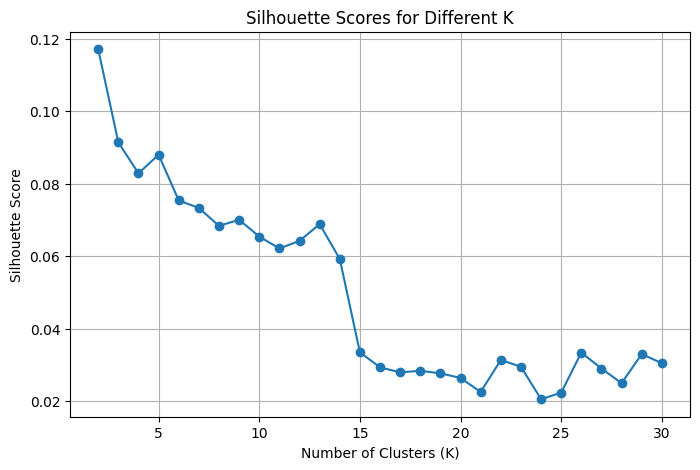

In [36]:
from sklearn.metrics import silhouette_score
from tqdm import tqdm

# Define range of k values
k_values = range(2, 31)  # Adjust the range as needed

# Store silhouette scores
silhouette_scores = []

# Calculate silhouette scores for each k
for k in tqdm(k_values, desc="Calculating Silhouette Scores"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reduced_matrix)  # Use the reduced matrix for clustering
    labels = kmeans.labels_

    # Compute the silhouette score
    score = silhouette_score(reduced_matrix, labels)
    silhouette_scores.append(score)

    print(f"K={k}, Silhouette Score={score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()
